In [5]:
import pandas as np
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt


In [6]:
from google.colab import files
uploaded = files.upload()


Saving Cat.zip to Cat (1).zip
Saving Dog.zip to Dog (1).zip


In [7]:
# Create a base folder for all data
os.makedirs("dataset", exist_ok=True)

# Extract Cat.zip
with zipfile.ZipFile("Cat.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset/cats")

# Extract Dog.zip
with zipfile.ZipFile("Dog.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset/dogs")

# Check folder structure
os.listdir("dataset")


['cats', 'dogs']

In [8]:

# Load dataset from the main directory
dataset = tf.keras.utils.image_dataset_from_directory(
    "dataset",              # main folder
    image_size=(150, 150),  # resize all images to 150x150
    batch_size=32,          # number of images per batch
    shuffle=True            # shuffle for training
)

# Check class names
print("Classes:", dataset.class_names)


Found 15158 files belonging to 2 classes.
Classes: ['cats', 'dogs']


In [21]:
import tensorflow as tf
import os

base_dir = "dataset"

# Try loading each image individually with TensorFlow
def check_images_with_tf(base_dir):
    bad_files = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            path = os.path.join(root, file)
            try:
                # Try to decode using TensorFlow (same method as image_dataset_from_directory)
                img = tf.io.read_file(path)
                img = tf.image.decode_image(img, channels=3)
            except Exception as e:
                print("❌ Bad file:", path)
                bad_files.append(path)
    return bad_files

bad_files = check_images_with_tf(base_dir)
print(f"\nTotal TensorFlow decode errors: {len(bad_files)}")


❌ Bad file: dataset/cats/Cat/10404.jpg
❌ Bad file: dataset/dogs/Dog/2317.jpg
❌ Bad file: dataset/dogs/Dog/11233.jpg
❌ Bad file: dataset/dogs/Dog/11912.jpg
❌ Bad file: dataset/dogs/Dog/2494.jpg
❌ Bad file: dataset/dogs/Dog/9500.jpg

Total TensorFlow decode errors: 6


In [22]:
for f in bad_files:
    os.remove(f)
print("✅ Removed bad files successfully.")


✅ Removed bad files successfully.


In [15]:
from PIL import Image
import os

def clean_dataset(directory):
    corrupted = 0
    for root, _, files in os.walk(directory):
        for file in files:
            path = os.path.join(root, file)
            try:
                img = Image.open(path)
                img.verify()  # Validate file
            except Exception as e:
                print("Removing corrupted image:", path)
                os.remove(path)
                corrupted += 1
    print(f"\n✅ Done! Removed {corrupted} corrupted or unreadable images.")

clean_dataset("dataset")


Removing corrupted image: dataset/cats/Cat/Thumbs.db
Removing corrupted image: dataset/dogs/Dog/Thumbs.db
Removing corrupted image: dataset/dogs/Dog/11702.jpg


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))



✅ Done! Removed 3 corrupted or unreadable images.


In [23]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(150, 150),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(150, 150),
    batch_size=32
)


Found 15151 files belonging to 2 classes.
Using 12121 files for training.
Found 15151 files belonging to 2 classes.
Using 3030 files for validation.


In [24]:
# Normalize pixel values (0–1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [25]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # binary output
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [27]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.8285 - loss: 0.4610 - val_accuracy: 0.8343 - val_loss: 0.3899
Epoch 2/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8359 - loss: 0.3863 - val_accuracy: 0.8323 - val_loss: 0.4026
Epoch 3/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.8508 - loss: 0.3500 - val_accuracy: 0.8479 - val_loss: 0.3733
Epoch 4/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.8714 - loss: 0.3082 - val_accuracy: 0.8498 - val_loss: 0.3789
Epoch 5/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.8880 - loss: 0.2555 - val_accuracy: 0.8690 - val_loss: 0.3688
Epoch 6/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9147 - loss: 0.2027 - val_accuracy: 0.8703 - val_loss: 0.4050
Epoch 7/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9319 - loss: 0.1633 - val_accuracy: 0.8693 - val_loss: 0.4804
Epoch 8/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9547 - loss: 0.1132 - 

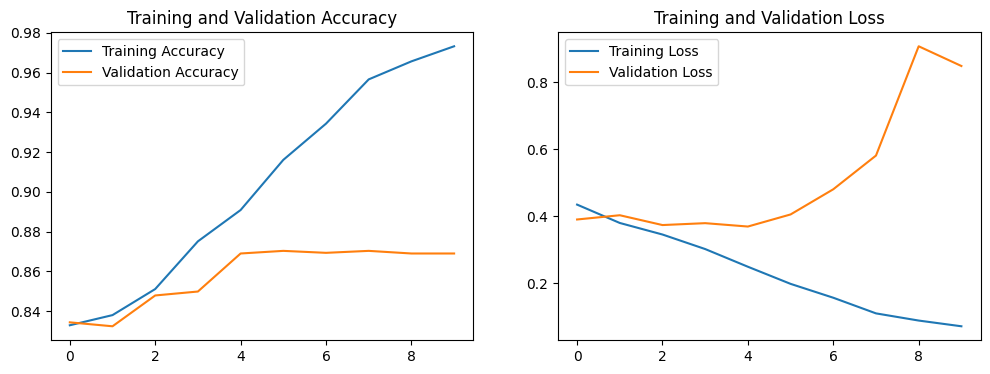

In [28]:
# visualize model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [30]:
# save model
model.save('cat_dog_classifier.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "dataset/cats/cat1.jpg"  # change to test image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # add batch dimension

prediction = model.predict(img_array)

if prediction[0] > 0.5:
    print("Prediction: 🐶 Dog")
else:
    print("Prediction: 🐱 Cat")


In [ ]:
model.save("cat_dog_model.h5")
